In [1]:
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib.dates as mdates


In [2]:
#########################################
#########################################
### INIT
#########################################
#########################################

data_folder = "/home/cesardb/Documents/recherche/travail/ATLAS_SantanderMetGroup/data/ATLAS-main/datasets-aggregated-regionally/data"
region = "MED" # "world" see https://github.com/SantanderMetGroup/ATLAS/blob/main/reference-regions/reference_regions.png
months_to_select = [12, 1, 2, 3, 4, 5]
n_month = len(months_to_select)
ref_date = "1989-03-01" # center of the 30 year reference period
fut_date = "2050-03-01" # center of the 30 year future interest period
run_list = ["historical", "rcp26", "rcp45", "rcp85"]

plt_dict = {
    "historical":{"col":"#4a4e4d", "mrk":"v"},
    "rcp26":{"col":"#f6cd61", "mrk":"^"},
    "rcp45":{"col":"#fe8a71", "mrk":"^"},
    "rcp85":{"col":"#851e3e", "mrk":">"},
    "DJF":{"col":"#0057e7","mrk":"*"},
    "MAM":{"col":"#008744","mrk":"s"},
    "JJA":{"col":"#d62d20","mrk":"."},
    "SON":{"col":"#ffa700","mrk":"^"},
    }


In [3]:
# GET CMIP5 TEMPERATURE AND PRECIP DATA

# Find common gcm to all run

file_list = glob.glob( data_folder + "/CMIP5/CMIP5_tas_landsea/*" )
gcm_dict = {"historical":[], "rcp26":[], "rcp45":[], "rcp85":[]}
for file in file_list:
    gcm = ("_").join(file.split("/")[-1].split("_")[:-1])
    run = file.split("/")[-1].split("_")[-1].replace(".csv", "")
    gcm_dict[run].append(gcm)

gcm_common_list = list(set(gcm_dict["rcp26"]) & set(gcm_dict["rcp45"]) & set(gcm_dict["rcp85"]))

#############################
#############################
### CMIP5 TAS
#############################
#############################
     
tas_dict_all = {"historical":{}, "rcp26":{}, "rcp45":{}, "rcp85":{}}

for run in run_list:
    for gcm in gcm_common_list:
        in_file = glob.glob( data_folder + "/CMIP5/CMIP5_tas_landsea/*"+gcm+"*"+run+"*.csv" )[0]
        data = pd.read_csv(in_file, skiprows=15)[["date", region]]
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data = data.to_xarray()
        data = data.sel({"date":data.date.dt.month.isin(months_to_select)})
        
        if run == "historical":
            data = data.sel(date=slice("1970-12-31","2005-12-01"))
        else:
            data = data.sel(date=slice("2005-12-31","2099-01-01"))

        tas_dict_all[run][gcm] = data
    
#############################
#############################
### CMIP5 PR
#############################
#############################

pr_dict_all =  {"historical":{}, "rcp26":{}, "rcp45":{}, "rcp85":{}}
for run in run_list:
    for gcm in gcm_common_list:
        in_file = glob.glob( data_folder + "/CMIP5/CMIP5_pr_landsea/*"+gcm+"*"+run+"*.csv" )[0]
        data = pd.read_csv(in_file, skiprows=15)[["date", region]]
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data = data.to_xarray()
        data = data.sel({"date":data.date.dt.month.isin(months_to_select)})
        
        if run == "historical":
            data = data.sel(date=slice("1970-12-31","2005-12-01"))
        else:
            data = data.sel(date=slice("2005-12-31","2099-01-01"))
        pr_dict_all[run][gcm] = data
    
#############################
#############################
### OBS TAS
#############################
#############################
file = data_folder + "/OBSERVATIONS/OBS_tas_landsea/W5E5.csv"
data = pd.read_csv(file, skiprows=14)[["date", region]]
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
# Create a boolean mask to select the desired months
selected_months_mask = data.index.month.isin(months_to_select)

# Use the boolean mask to select the data for the desired months
tas_obs = data[selected_months_mask]    


In [4]:
anomaly_cmip5_common = {"rcp26":{}, "rcp45":{}, "rcp85":{}}
data4env = {"rcp26":[], "rcp45":[], "rcp85":[]}

for gcm in gcm_common_list:
    for run in ["rcp26", "rcp45", "rcp85"]:
        data_clim_mean = xr.merge([tas_dict_all["historical"][gcm], tas_dict_all[run][gcm]]).rolling(date = 30*n_month, center=True).mean()
      
        data_ref = data_clim_mean.sel(date=ref_date)
        anomaly_cmip5_common[run][gcm] = data_clim_mean.sel(date=fut_date) - data_ref
        data4env[run].append( data_clim_mean - data_ref )

(np.float64(0.0), np.float64(32872.0))


/home/cesardb/.local/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Text(0.5, 0.98, 'Temperature anomaly Mediteranean area')

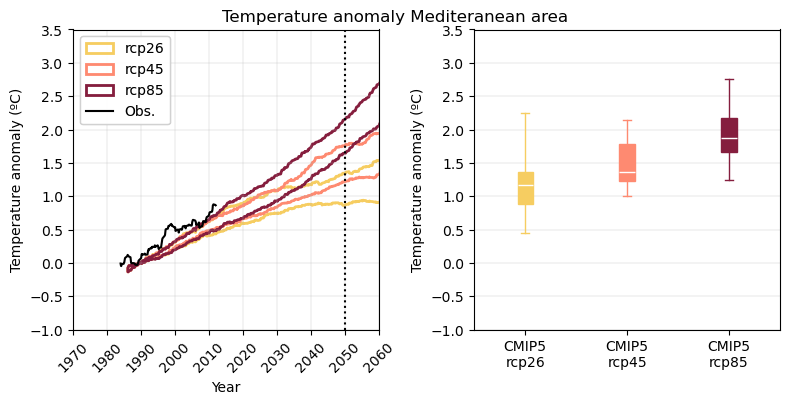

In [18]:

# CMIP5 AVAILABLE FROM SUBSET AVAILABLE in rcp26, rcp45, rcp85
plt.figure(figsize=(8,4))

        
plt.subplot(121)
for run in ["rcp26", "rcp45", "rcp85"]:
    a = xr.concat(data4env[run], dim="gcm")
#    plt.fill_between(a.date, a.min(dim={"gcm"}), a.max(dim={"gcm"}), color= plt_dict[run]["col"], alpha=0.4, label=run)
#     plt.fill_between(a.date, a.min(dim={"gcm"})[region],
#                      a.max(dim={"gcm"})[region],
#                      facecolor=[0,0,0,0],
#                      edgecolor = plt_dict[run]["col"],
#                      label=run,
#                      lw=2
#                     )
    
    plt.fill_between(a.date, 
                     a.quantile(0.25, dim={"gcm"})[region],
                     a.quantile(0.75, dim={"gcm"})[region],
                     facecolor=[0,0,0,0],
                     edgecolor = plt_dict[run]["col"],
                     label=run,
                     lw=2
                    )
    
tt = tas_obs.rolling(n_month*10, center=True).mean()
tas_obs_anomaly = tt - tt.loc[ref_date]
plt.plot(tas_obs_anomaly, "k", label="Obs.")

# Create a YearLocator to specify the tick locations every 10 years
year_locator = mdates.YearLocator(base=10)

# Create a DateFormatter to format the tick labels as years
year_format = mdates.DateFormatter('%Y')

# Set the x-axis locator and formatter
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_format)
plt.xticks(rotation=45)
plt.grid(True,lw=0.2)
plt.xlim(pd.to_datetime('1970-01-01'), pd.to_datetime('2060-01-01'))
plt.vlines(pd.to_datetime(fut_date), -1, 3.5, lw=1.5, color="k", ls=":")
plt.ylim([-1, 3.5])
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (ºC)')
print(plt.gca().get_xlim())


# Get the current legend
legend = plt.legend()

# Create a dictionary to store unique labels and their corresponding handles
unique_labels = {}

# Iterate through legend entries and collect unique labels and handles
for handle, label in zip(legend.legend_handles, legend.get_texts()):
    if label.get_text() not in unique_labels:
        unique_labels[label.get_text()] = handle

# Create a new legend with unique labels and handles
new_legend = plt.legend(handles=list(unique_labels.values()), labels=list(unique_labels.keys()), loc="upper left")

# Add the new legend to the plot
plt.gca().add_artist(new_legend)



plt.subplot(122)
#plt.boxplot([ anomaly_cordex_ens[ff] for ff in anomaly_cordex_ens.keys()], showfliers=False, positions=[0])

for ii, run in enumerate(["rcp26", "rcp45", "rcp85"]):
    plt.boxplot([ anomaly_cmip5_common[run][ff][region].values.flatten()[0] for ff in anomaly_cmip5_common[run].keys()], 
                showfliers=False, 
                positions=[ii],
                patch_artist=True, 
                whis=1e9,
                boxprops = { "facecolor":plt_dict[run]["col"], "color":plt_dict[run]["col"]},
                capprops = { "color":plt_dict[run]["col"]},
                whiskerprops = { "color":plt_dict[run]["col"]},
                medianprops = { "color":"w"}
                )

plt.ylim([-1, 3.5])
plt.xticks([0,1,2], ["CMIP5\nrcp26", "CMIP5\nrcp45", "CMIP5\nrcp85"])
plt.grid(True,lw=0.2,axis="y")
plt.ylabel('Temperature anomaly (ºC)')
plt.tight_layout()

plt.suptitle("Temperature anomaly Mediteranean area", ha='center', va='center')
#plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050.png")
#plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050.svg")
